In [76]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [77]:
coinbase_tickers = pickle.load(open('data/crypto/iterables/coinbase_tickers.pkl', 'rb'))
time_intervals = pickle.load(open('data/crypto/iterables/time_intervals.pkl', 'rb'))

In [78]:
def check_performance(df):
    temp = []
    for arr in df:
        temp.append(sum(arr))
    count, total = 0, 0
    for elem in temp:
        if elem >= 0:
            count += 1
        total += elem
    return count, total

In [131]:
def pnl_calc(data):
    pnl_period = []
    for idx, row in data.iterrows():
        pred_diff = row['open'] - row['pred']
        actual_diff = row['open'] - row['close']
        # skip predictions that expect the crypto to go down since cant short anyways
        if pred_diff < 0:
            continue
        elif pred_diff >= 0 and actual_diff >= 0:
            pnl_period.append(abs(actual_diff) / row['open'])
        else:
            pnl_period.append(-1*abs(actual_diff) / row['open'])
    return np.array(pnl_period)

In [119]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [120]:
def get_pnl_for_time(bartime):
    pnl_data = []
    for ticker in coinbase_tickers:
        data = pd.read_csv('data/crypto/predicted/gaussian/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        data = pnl_calc(data)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

In [121]:
def plot_pnl(pnl_data, plt_col, plt_rows, gen_rand=False, with_title=False):
    fig, axs = plt.subplots(plt_rows, plt_col)
    plt.tight_layout(pad=.5)
    ymin, ymax = -0.5, 0.5
    plotted_idx = []
    for i in range(0,plt_rows):
        for j in range(0,plt_col):
            idx = (i * plt_col) + j
            if gen_rand:
                idx = random.randint(0,len(coinbase_tickers)-1) # random index value
                while idx in plotted_idx:
                    idx = random.randint(0,len(coinbase_tickers)-1) # generated until get a new ticker
                plotted_idx.append(idx)
            # reached end
            if idx >= len(pnl_data):
                break
            color = 'r' if sum(pnl_data[idx]) < 0 else 'b'
            axs[i,j].plot(pnl_data[idx], linewidth=0.5, color=color)
            axs[i,j].set_ylim([ymin, ymax])
            if with_title:
                axs[i,j].set_title(coinbase_tickers[idx], fontsize=10)
    for ax in axs.flat:
        ax.label_outer()

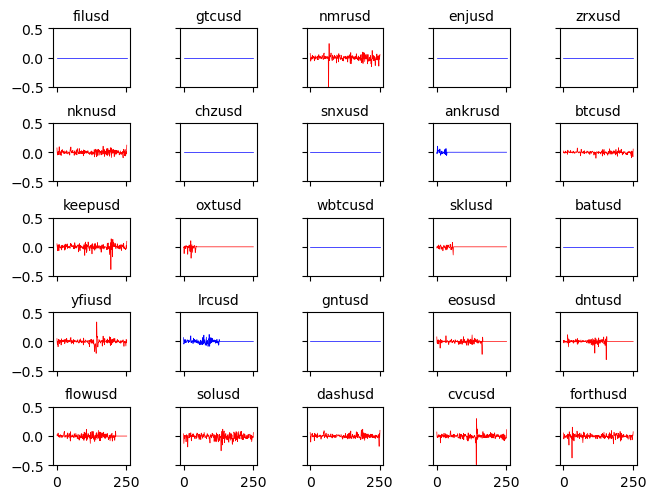

In [132]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_day_data = get_pnl_for_time('1_day')
plot_pnl(pnl_day_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [123]:
day_1_bench = check_performance(pnl_day_data)
day_1_bench

(27, -30.1448748634182)

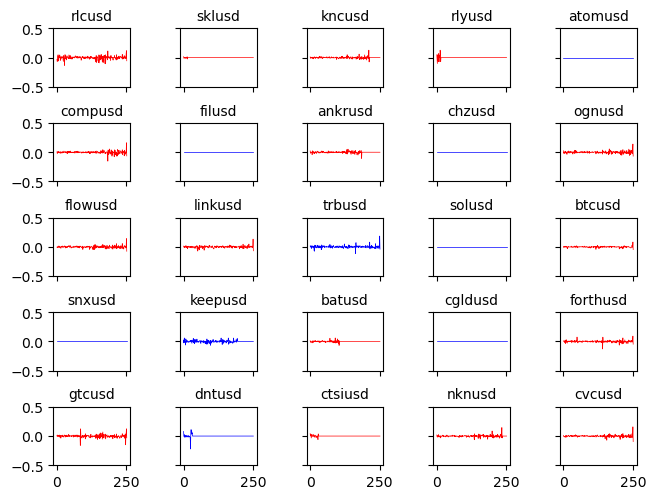

In [124]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_4h_data = get_pnl_for_time('4_hour')
plot_pnl(pnl_4h_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [125]:
hour_4_bench = check_performance(pnl_4h_data)
hour_4_bench

(22, -11.655043399161674)

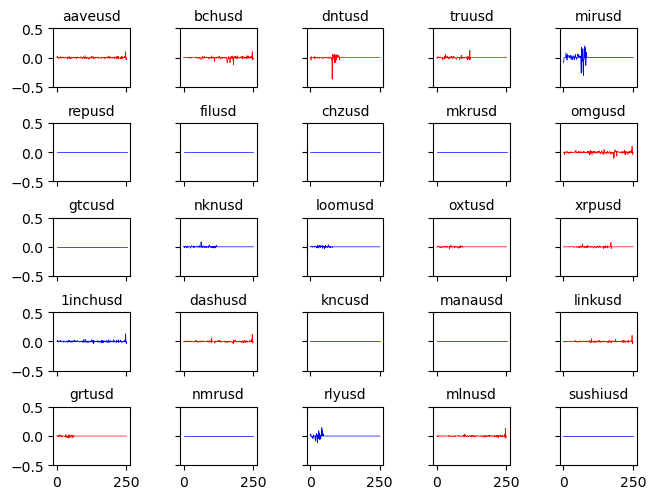

In [126]:
# generate 25 random samples
# set plt_col=25, plt_row=26 for max
pnl_1h_data = get_pnl_for_time('1_hour')
plot_pnl(pnl_1h_data, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [127]:
hour_1_bench = check_performance(pnl_1h_data)
hour_1_bench

(37, -2.473384318377774)

In [102]:
def pnl_calc_sd(data, sd, modif):
    pnl_period = []
    for idx, row in data.iterrows():
        pred_diff = round(row['pred'] - row['open'], 2)
        actual_diff = round(row['close'] - row['open'], 2)
        low_diff = abs(round(row['low'] - row['open'], 2))
        high_diff = abs(round(row['high'] - row['open'], 2))
        # throw out trades that go beyond 1 SD in opposite direction
        if ((pred_diff > 0 and low_diff <= modif*sd and actual_diff > 0) or 
            (pred_diff < 0 and high_diff <= modif*sd and actual_diff < 0)):
            pnl_period.append(abs(actual_diff))
        elif (pred_diff > 0 and low_diff > modif*sd) or (pred_diff < 0 and high_diff > modif*sd):
            pnl_period.append(-1*modif*sd)
        else: # take the loss less than sd
            pnl_period.append(-1*abs(actual_diff))
    return np.array(pnl_period)

In [103]:
def get_pnl_for_time_sd(bartime, modif):
    pnl_data = []
    df_summary = pd.read_csv('stock/data/pnl/gaussian/pnl_summary.csv', header=[0], index_col=[0])
    for ticker in sp500_tickers:
        data = pd.read_csv('stock/data/predicted/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        label = bartime + '_std'
        sd = df_summary.at[ticker,label]
        data = pnl_calc_sd(data, sd, modif)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

In [91]:
pnl_day_data_sd = get_pnl_for_time_sd('1_day', 3)
plot_pnl(pnl_day_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)


FileNotFoundError: [Errno 2] No such file or directory: 'stock/data/pnl/gaussian/pnl_summary.csv'

In [151]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_day_data_sd)
diff_ticker_count = profitable_tickers - day_1_bench[0]
diff_total_pnl = total_pnl - day_1_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-3
-512.8462686307953


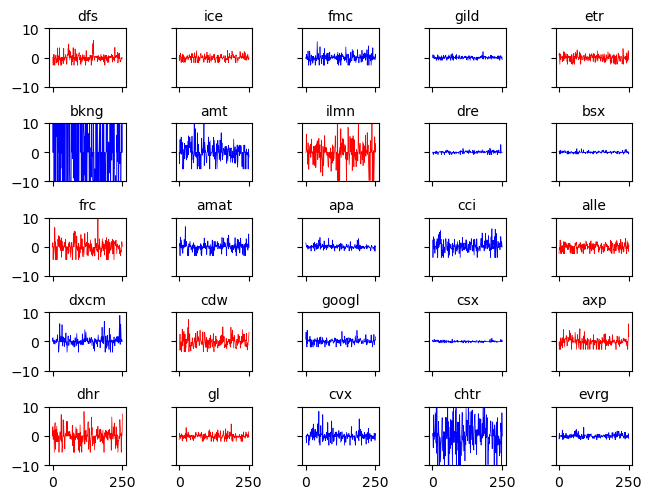

In [162]:
pnl_4h_data_sd = get_pnl_for_time_sd('4_hour', 2)
plot_pnl(pnl_4h_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [163]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_4h_data_sd)
diff_ticker_count = profitable_tickers - hour_4_bench[0]
diff_total_pnl = total_pnl - hour_4_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-1
289.3799999999986


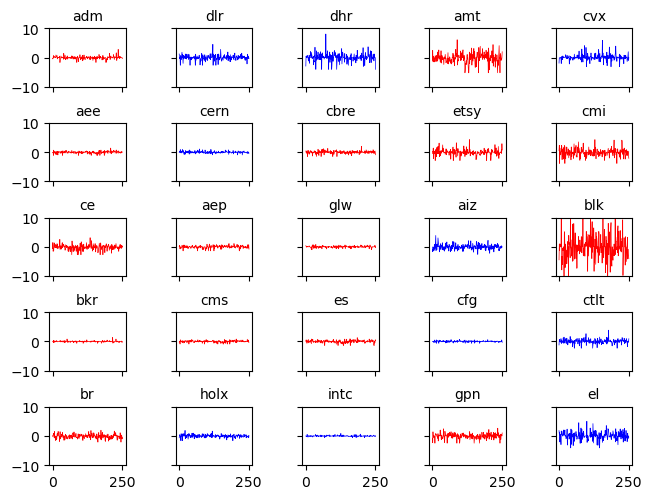

In [154]:
pnl_1h_data_sd = get_pnl_for_time_sd('1_hour', 3)
plot_pnl(pnl_1h_data_sd, plt_col=5, plt_rows=5, gen_rand=True, with_title=True)

In [155]:
#compare to bench
profitable_tickers, total_pnl = check_performance(pnl_1h_data_sd)
diff_ticker_count = profitable_tickers - hour_1_bench[0]
diff_total_pnl = total_pnl - hour_1_bench[1]
print(diff_ticker_count)
print(diff_total_pnl)

-2
-276.36


Incomplete still wroking on

In [156]:
# visualize the high low differences

In [171]:
def high_low_diff(data):
    high_diff = data['high'].sub(data['open'], axis=0)
    low_diff = data['low'].sub(data['open'], axis=0)
    print(low_diff)
    print(high_diff)

In [ ]:
def get_high_low_for_time(bartime):
    high_diff, low_diff = [], []
    for ticker in sp500_tickers:
        data = pd.read_csv('stock/data/predicted/{t}/{t}_{b}_pred.csv'.format(t=ticker,b=bartime))
        data = pnl_calc(data)
        pnl_data.append(data)
    for idx, row in enumerate(pnl_data):
        pnl_data[idx] = padarray(row, 252)
    pnl_data = np.array(pnl_data)
    return pnl_data

In [ ]:
pnl_day_data = get_pnl_for_time('1_day')
high_low_diff(pnl_day_data)

In [75]:
pnl_1_day = pd.read_csv("data/crypto/pnl/gaussian/pnl_1_day_summary.csv")
pnl_1_day

,ticker,1_day_pnl,1_day_open_avg,1_day_mean,1_day_std,1_day_var
0,btcusd,-0.797554,36025.720992,-0.003165,0.022757,0.000518
1,ethusd,0.707162,2054.795794,0.002806,0.023810,0.000567
2,xrpusd,-0.494486,0.574706,-0.001962,0.053690,0.002883
3,bchusd,-0.865587,240.052857,-0.003435,0.053128,0.002823
4,ltcusd,0.046266,73.447151,0.000184,0.033446,0.001119
...,...,...,...,...,...,...
61,mirusd,2.523804,0.020325,0.010015,0.095904,0.009198
62,axsusd,-0.671068,6.317775,-0.002663,0.038189,0.001458
63,lptusd,1.746825,6.949881,0.006932,0.080638,0.006503
64,flowusd,-0.077934,0.657200,-0.000339,0.038288,0.001466


In [70]:
pnl_4_hour = pd.read_csv("data/crypto/pnl/gaussian/pnl_4_hour_summary.csv")
pnl_4_hour

,ticker,4_hour_pnl,4_hour_open_avg,4_hour_mean,4_hour_std,4_hour_var
0,btcusd,-0.482120,49638.176032,-0.001913,0.011020,0.000121
1,ethusd,-0.485821,2726.548770,-0.001928,0.012283,0.000151
2,xrpusd,-0.167068,0.544312,-0.000663,0.013743,0.000189
3,bchusd,-0.645920,276.319921,-0.002563,0.026805,0.000719
4,ltcusd,-0.254583,71.767806,-0.001010,0.014635,0.000214
...,...,...,...,...,...,...
61,mirusd,3.333191,0.024909,0.013227,0.066578,0.004433
62,axsusd,-0.261349,7.962037,-0.001037,0.017395,0.000303
63,lptusd,0.795679,10.598968,0.003157,0.039483,0.001559
64,flowusd,-0.514234,0.891242,-0.002041,0.019238,0.000370


In [71]:
pnl_1_hour = pd.read_csv("data/crypto/pnl/gaussian/pnl_1_hour_summary.csv")
pnl_1_hour

,ticker,1_hour_pnl,1_hour_open_avg,1_hour_mean,1_hour_std,1_hour_var
0,btcusd,-0.234568,59530.104206,-0.000931,0.007583,0.000057
1,ethusd,-0.202602,3339.730754,-0.000804,0.008333,0.000069
2,xrpusd,-0.022138,0.593061,-0.000088,0.010098,0.000102
3,bchusd,-0.443232,350.339524,-0.001759,0.018329,0.000336
4,ltcusd,0.210404,80.881426,0.000835,0.012390,0.000154
...,...,...,...,...,...,...
61,mirusd,2.355409,0.038659,0.009347,0.058602,0.003434
62,axsusd,-0.183269,9.406152,-0.000727,0.014896,0.000222
63,lptusd,0.063648,14.184405,0.000253,0.016511,0.000273
64,flowusd,-0.129056,1.109151,-0.000512,0.014710,0.000216


In [72]:
pnl_15_minute = pd.read_csv("data/crypto/pnl/gaussian/pnl_15_minute_summary.csv")
pnl_15_minute

,ticker,15_minute_pnl,15_minute_open_avg,15_minute_mean,15_minute_std,15_minute_var
0,btcusd,0.018124,65015.687698,0.000072,0.005211,0.000027
1,ethusd,0.068017,3558.008770,0.000270,0.005546,0.000031
2,xrpusd,-0.057792,0.635357,-0.000229,0.006789,0.000046
3,bchusd,0.157882,452.618730,0.000627,0.009997,0.000100
4,ltcusd,-0.071989,89.286755,-0.000286,0.007331,0.000054
...,...,...,...,...,...,...
61,mirusd,0.314159,0.070591,0.001247,0.056607,0.003204
62,axsusd,-0.060469,10.461643,-0.000240,0.009629,0.000093
63,lptusd,-0.088207,14.072897,-0.000350,0.010065,0.000101
64,flowusd,0.001342,1.213845,0.000005,0.009661,0.000093


In [73]:
pnl_5_minute = pd.read_csv("data/crypto/pnl/gaussian/pnl_5_minute_summary.csv")
pnl_5_minute

,ticker,5_minute_pnl,5_minute_open_avg,5_minute_mean,5_minute_std,5_minute_var
0,btcusd,-0.104659,65943.648571,-0.000415,0.004390,0.000019
1,ethusd,-0.016323,3661.827540,-0.000065,0.004776,0.000023
2,xrpusd,-0.087946,0.628668,-0.000349,0.005614,0.000032
3,bchusd,0.119318,431.034484,0.000473,0.006904,0.000048
4,ltcusd,-0.086098,87.092136,-0.000342,0.005879,0.000035
...,...,...,...,...,...,...
61,mirusd,0.577192,0.119893,0.002290,0.046789,0.002189
62,axsusd,-0.091478,10.402209,-0.000363,0.007352,0.000054
63,lptusd,0.075067,14.051905,0.000298,0.007623,0.000058
64,flowusd,0.119662,1.196290,0.000475,0.006770,0.000046


In [133]:
def check_invidual_performance(df):
    df['pred_diff'] = df['pred'].sub(df['open'])
    df['actual_diff'] = df['close'].sub(df['open'])
    win_loss = []
    for idx,row in df.iterrows():
        if row['pred_diff'] < 0:
            win_loss.append(0)
        elif row['pred_diff'] > 0 and row['actual_diff'] > 0:
            win_loss.append(1)
        else:
            win_loss.append(-1)
    df['win_loss'] = win_loss
    return win_loss

In [134]:
def count_win_loss(array):
    wins, losses = 0, 0
    for item in array:
        if item == 1:
            wins+=1
        if item == -1:
            losses+=1
    return wins,losses

In [137]:
bartime = '4_hour'
for ticker in coinbase_tickers:
    data = pd.read_csv(f'data/crypto/predicted/gaussian/{ticker}/{ticker}_{bartime}_pred.csv')
    array = check_invidual_performance(data)
    if ticker == 'solusd':
        print(sum(array))
    wins,losses = count_win_loss(array)
    print(f'Ticker: {ticker}, Wins: {wins}, Losses: {losses}')
    
    

Ticker: btcusd, Wins: 0, Losses: 0
Ticker: ethusd, Wins: 0, Losses: 0
Ticker: xrpusd, Wins: 0, Losses: 0
Ticker: bchusd, Wins: 0, Losses: 0
Ticker: ltcusd, Wins: 0, Losses: 0
Ticker: eosusd, Wins: 0, Losses: 0
Ticker: dashusd, Wins: 0, Losses: 0
Ticker: linkusd, Wins: 0, Losses: 0
Ticker: zrxusd, Wins: 135, Losses: 113
Ticker: etcusd, Wins: 137, Losses: 115
Ticker: xtzusd, Wins: 87, Losses: 106
Ticker: oxtusd, Wins: 126, Losses: 103
Ticker: repusd, Wins: 116, Losses: 136
Ticker: atomusd, Wins: 140, Losses: 112
Ticker: algousd, Wins: 144, Losses: 108
Ticker: dntusd, Wins: 99, Losses: 125
Ticker: batusd, Wins: 83, Losses: 65
Ticker: cvcusd, Wins: 0, Losses: 0
Ticker: manausd, Wins: 0, Losses: 0
Ticker: kncusd, Wins: 24, Losses: 19
Ticker: loomusd, Wins: 25, Losses: 32
Ticker: gntusd, Wins: 0, Losses: 0
Ticker: nuusd, Wins: 7, Losses: 5
Ticker: mkrusd, Wins: 137, Losses: 115
Ticker: nmrusd, Wins: 0, Losses: 0
Ticker: omgusd, Wins: 143, Losses: 109
Ticker: rlcusd, Wins: 0, Losses: 0
Ticker